In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jedi
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

## Load Data and Basic Info

In [2]:
# import data
df = pd.read_csv("conversion_project.csv")
# data overview
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


The average total page visited is around 5 pages, with more than 75% visit at least 2 pages.

The average age of customers is 31 years old, with only 25% of them exceeding 36 years old. The maximum age is 123, doesn't seem right, let's look into it closer:

In [5]:
df[df.age>90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


The longest person ever lived on earth is 122 years old. It's more likely that someone randomly entered this two numbers. Let's remove them.

In [6]:
# drop age outlier rows
#df.drop(df[df.age>90].index, inplace=True)
df = df[df.age<90]

In [7]:
# Explore categorical variables
for col in df.columns:
    uniques = sorted(df[col].unique())
    print(col, len(uniques), uniques)
    #print('{0:20s} {1:5d}\t'.format(col, len(uniques)), uniques[:5])

country 4 ['China', 'Germany', 'UK', 'US']
age 58 [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 77, 79]
new_user 2 [0, 1]
source 3 ['Ads', 'Direct', 'Seo']
total_pages_visited 29 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
converted 2 [0, 1]


## Exploratory Data Analysis

(array([7.0571e+04, 8.2934e+04, 7.7755e+04, 5.1261e+04, 2.3848e+04,
        8.2810e+03, 1.3130e+03, 2.1600e+02, 1.6000e+01, 3.0000e+00]),
 array([17. , 23.2, 29.4, 35.6, 41.8, 48. , 54.2, 60.4, 66.6, 72.8, 79. ]),
 <a list of 10 Patch objects>)

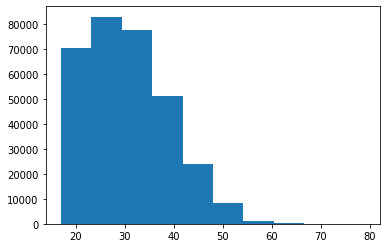

In [8]:
plt.hist(df.age)

(array([1.28436e+05, 1.07615e+05, 5.31670e+04, 1.70820e+04, 4.23600e+03,
        3.26900e+03, 1.69200e+03, 5.89000e+02, 1.02000e+02, 1.00000e+01]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <a list of 10 Patch objects>)

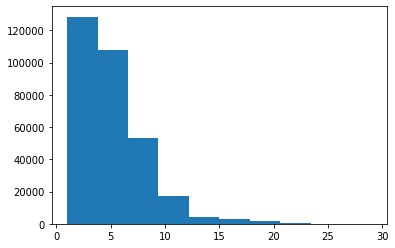

In [9]:
plt.hist(df.total_pages_visited)

Text(0.5, 1.0, 'Average Conversion Rate by Country')

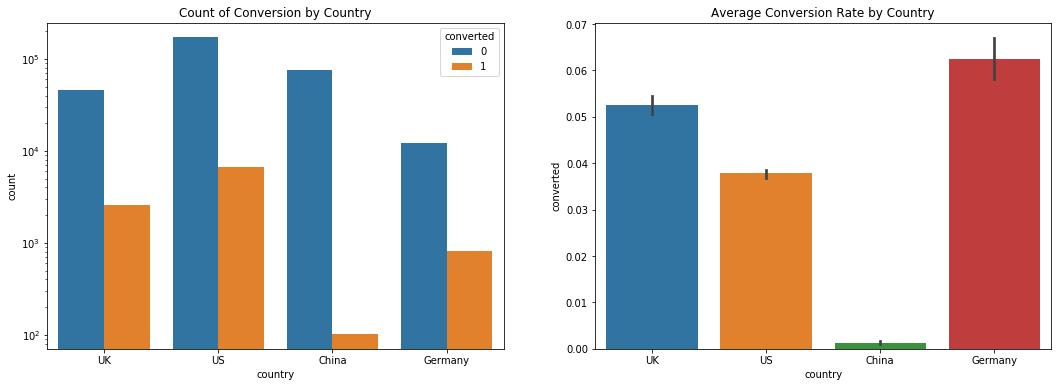

In [10]:
# Visualize for different countries
grouped = df[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
# Histogram by country
sns.countplot(x='country',hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count of Conversion by Country')
ax[0].set_yscale('log')
# Bar plot for conversion rate
sns.barplot(x='country', y='converted', data=df, ax=ax[1])
ax[1].set_title('Average Conversion Rate by Country')

Germany has the highest conversion rate of around 7% while China has a near zero conversion rate.

Text(0.5, 1.0, 'Conversion Rate by User Type')

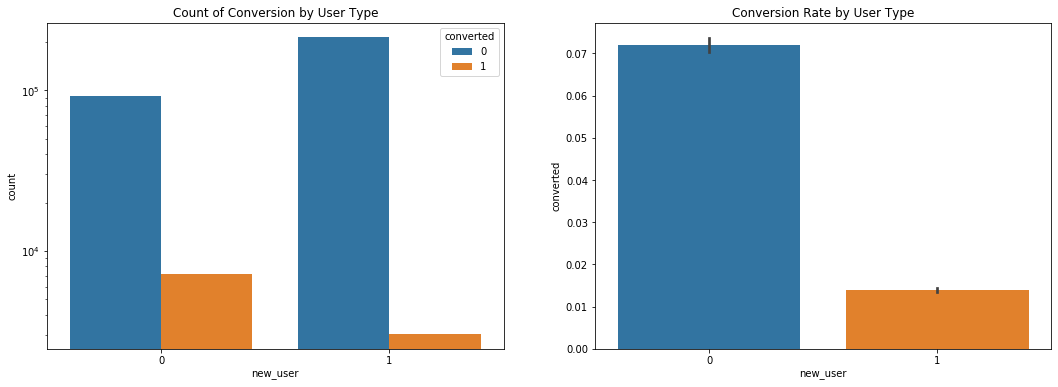

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
# Visualization by different user types
sns.countplot(x='new_user', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count of Conversion by User Type')
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=df, ax=ax[1])
ax[1].set_title('Conversion Rate by User Type')

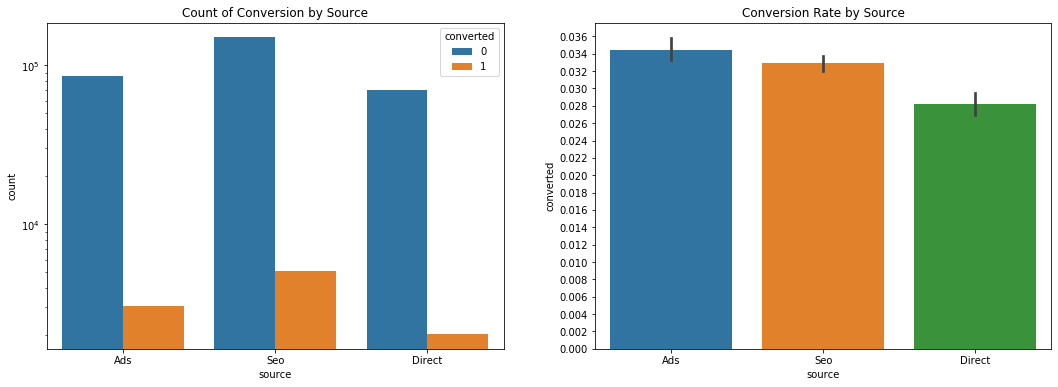

In [12]:
# Visualization by source
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.countplot(x='source',hue='converted',data=df,ax=ax[0])
ax[0].set_title('Count of Conversion by Source')
ax[0].set_yscale('log')
sns.barplot(x='source',y='converted',data=df,ax=ax[1])
ax[1].set_title('Conversion Rate by Source')
ax[1].set_yticks(np.arange(0,0.038,0.002))

Ads has the highest converstion rate of 3.4%. SEO is the second highest at 3.2%. Direct marketing has 2.8%.

Text(0, 0.5, 'Mean Conversion Rate')

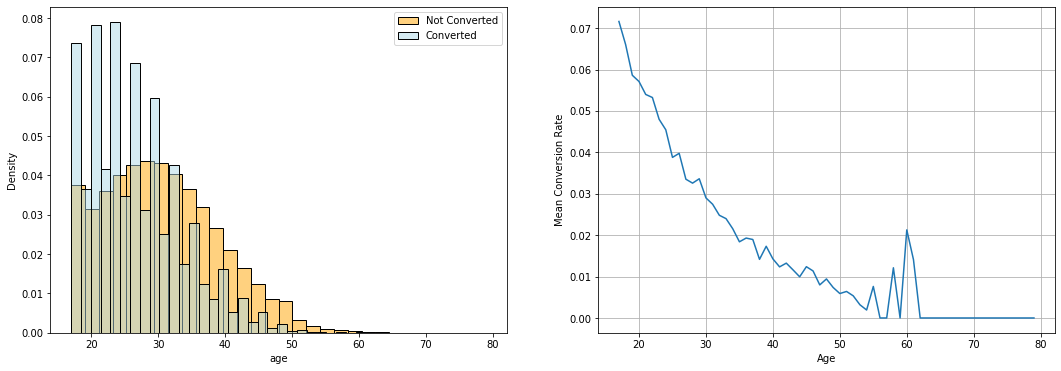

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# create a histogram of age by converted types
sns.histplot(df[df['converted']==0]['age'], label='Not Converted', stat='density', ax=ax[0], color='orange', bins=30, alpha=0.5)
sns.histplot(df[df['converted']==1]['age'], label='Converted', stat='density', ax=ax[0], color='lightblue', bins=30, alpha=0.5)
ax[0].legend()

ax[1].plot(df[['age', 'converted']].groupby(['age']).agg(['mean']))
ax[1].grid(True)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Mean Conversion Rate')

Seems older the age, less the conversion rate. However, we see a spike of conversion rate at around age 60.

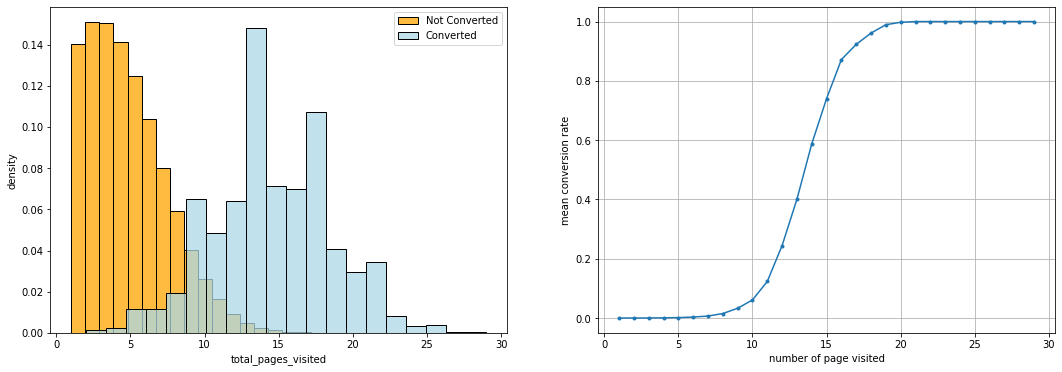

In [14]:
grouped_page = df[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

#hist_kws={"rwidth":3,'edgecolor':'black', 'alpha':1.0}
# Visualization by page visitied
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
#sns.displot(df[df.converted==0].total_pages_visited, label='Not Converted', ax=ax[0])
#ax[0].set_xticks(np.arange(0,22,1))

sns.histplot(df[df['converted'] == 0]['total_pages_visited'], 
             label='Not Converted', kde=False, stat='density', ax=ax[0], color='orange', bins=20)
sns.histplot(df[df['converted'] == 1]['total_pages_visited'], 
             label='Converted', kde=False, stat='density', ax=ax[0], color='lightblue', bins=20)
ax[0].set_ylabel('density')
ax[0].legend()

ax[1].plot(grouped_page.total_pages_visited, grouped_page.converted, '.-')
ax[1].set_xlabel('number of page visited')
ax[1].set_ylabel('mean conversion rate')
ax[1].grid(True)

Greater the total pages vistited, larger the conversion rate.

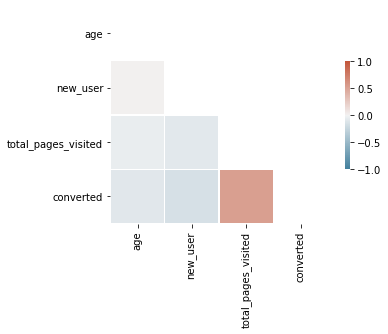

In [15]:
# correlation plot
corr = df.corr()
mask = np.triu(np.ones_like(corr,dtype=bool))
f, ax = plt.subplots()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1,center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Seems like 'total_pages_visited' is highly positively correlated with conversion. On the othe rhand, whether the user is a new user and the user's increasing age are moderately negatively correlated with conversion.

## Model Fitting

In [ ]:
# Initialize H2O Cluster
h2o.init()
h2o.remove_all()

In [ ]:
# Transform to H2O frame, make sure the target variable is categorical
h2o_df = H2OFrame(df)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

In [ ]:
# split the data into 80% training and 20% testing data set
split = h2o_df['converted'].stratified_split(test_frac=0.2, seed=42)

train = h2o_df[split=='train']
test = h2o_df[split=='test']

feature = df.iloc[:,0:5].columns.values
target = 'converted'

In [ ]:
# Build the random forest model
rf = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, mtries=-1, seed=42, score_each_iteration=True)

rf.train(x=feature.tolist(), y=target, training_frame=train)

In [ ]:
rf.varimp_plot()

In [ ]:
rf.varimp

In [ ]:
# make prediction
train_real = train.as_data_frame()['converted'].values
test_real = test.as_data_frame()['converted'].values
test_pred = rf.predict(test).as_data_frame()['p1'].values


In [ ]:
test_fpr, test_tpr, test_thresholds = roc_curve(test_real, test_pred)
test_auc = auc(test_fpr, test_tpr)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(test_fpr, test_tpr)
ax.set_title(label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
print(classification_report(y_true=test_real, y_pred=(test_pred>0.5).astype(int)))

In [ ]:
rf.partial_plot(test, cols=feature.tolist())

In [ ]:
h2o.cluster().shutdown()

## Try two other models: tree and logistic regression

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

### Preparation

In [17]:
# encode categorical features
le = preprocessing.LabelEncoder()
df.country = le.fit_transform(df.country)
df.source = le.fit_transform(df.source)

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:5], df.iloc[:,5], test_size=0.2, random_state=42)

### Tree Model

In [18]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred_dt))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61205
           1       0.84      0.66      0.74      2035

    accuracy                           0.98     63240
   macro avg       0.91      0.83      0.86     63240
weighted avg       0.98      0.98      0.98     63240



### Logistic Regression

In [19]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred_lr = dt.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred_lr))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61205
           1       0.84      0.66      0.74      2035

    accuracy                           0.98     63240
   macro avg       0.91      0.83      0.86     63240
weighted avg       0.98      0.98      0.98     63240



In [20]:
from sklearn.decomposition import PCA
from sklearn import svm
from mlxtend.plotting import plot_decision_regions

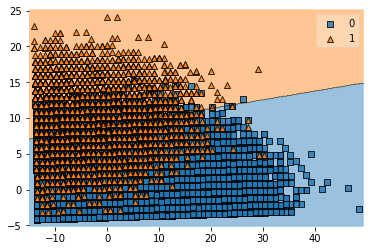

In [29]:
clfs = [logreg,dt]

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

logreg2 = LogisticRegression(random_state=42)
logreg2.fit(principalDf, y_train)

plot_decision_regions(principalDf.to_numpy(), y_train.to_numpy(), clf=logreg2)


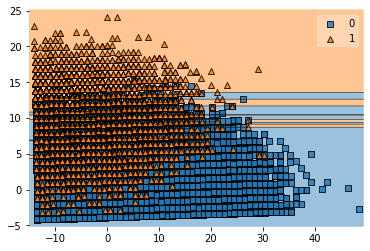

In [31]:
dt2 = DecisionTreeClassifier()
dt2.fit(principalDf, y_train)

plot_decision_regions(principalDf.to_numpy(), y_train.to_numpy(), clf=dt2)